In [1]:
#Stacked LSTMs with Memory Between Batches

#modules
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import haha
from sklearn.metrics import mean_squared_error

tf.random.set_seed(7)

In [3]:
#load dataset
df=pd.read_csv("../../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[-(30*15):]

In [4]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df.values.reshape(-1,1))

In [5]:
#train test split; train 12 months, 3 months for testing
train=df[:30*12]; test=df[30*12:]

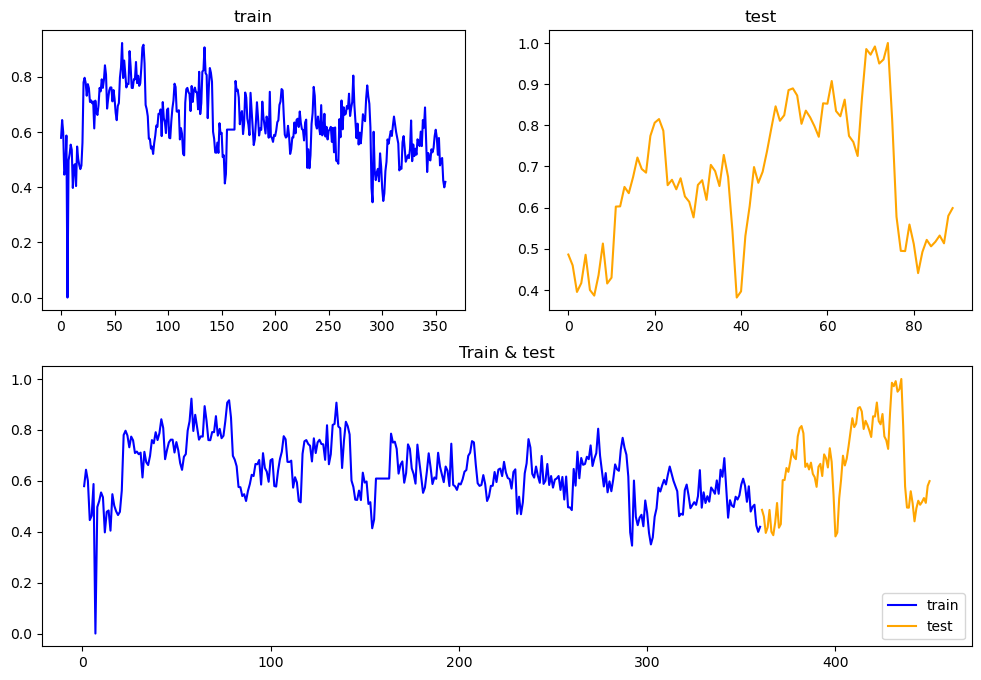

In [6]:
haha.plottraintest(train, test)

In [7]:
# reshape into X=t and Y=t+1

t=3
trainX, trainY = haha.lag(train,t)
testX, testY = haha.lag(test,t)

In [8]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [12]:
batch_size=1

#create model
def getmodel_compile():
    model=keras.Sequential([
        keras.layers.LSTM(4, batch_input_shape=(batch_size, t, 1), stateful=True, return_sequences=True), 
        keras.layers.LSTM(8, batch_input_shape=(batch_size, t, 1), stateful=True),
        keras.layers.Dense(1)])                  
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=keras.metrics.RootMeanSquaredError())
    return model

In [13]:
model=getmodel_compile()

for i in range(100):
    model.fit(trainX, trainY, epochs=1, validation_data=(testX, testY), batch_size=batch_size, verbose=1)

356/356 [==============================] - 3s 7ms/step - loss: 0.0053 - root_mean_squared_error: 0.0725 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0730


In [15]:
#Lets predict and check performance metrics
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

86/86 [==============================] - 0s 3ms/step


In [16]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

df=scaler.inverse_transform(df)
testY = scaler.inverse_transform([testY])
trainY = scaler.inverse_transform([trainY])

In [17]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 5.64 RMSE
Test Score: 5.79 RMSE


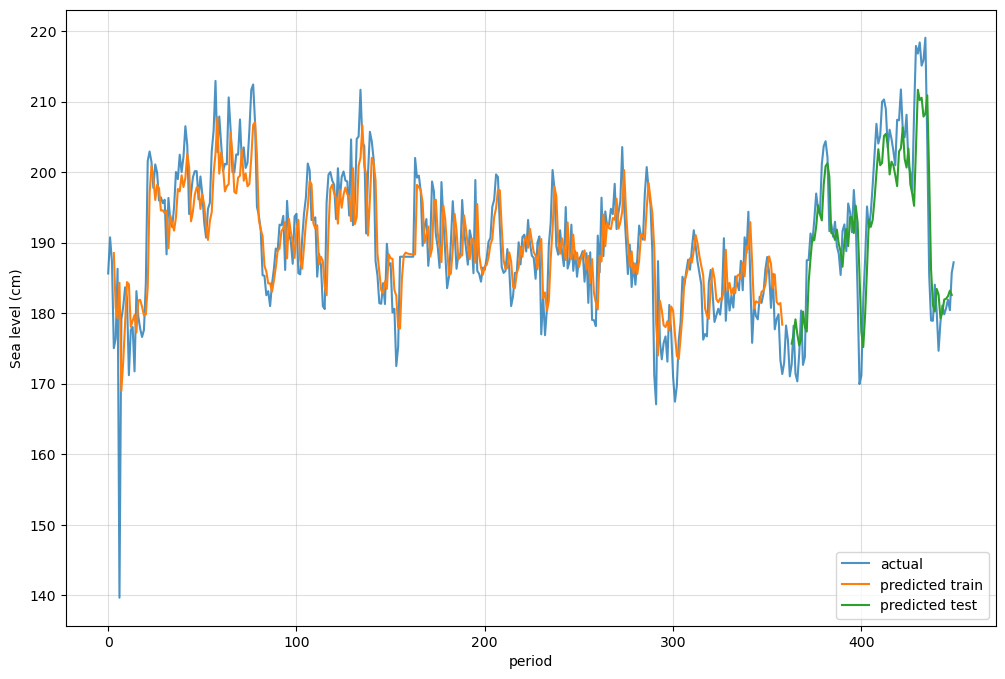

In [18]:
haha.plot_predicted(df, trainPredict, testPredict, t)

Predict the next 30 days

#Not finished

In [194]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [195]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

ValueError: cannot reshape array of size 88 into shape (1,100,1)

In [115]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [116]:
df3 = df_close.tolist()
df3.extend(lst_output)

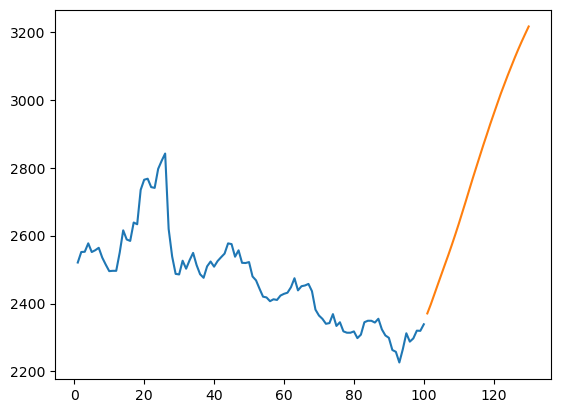

In [118]:
plt.plot(day_new, scaler.inverse_transform(df_close[-100:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

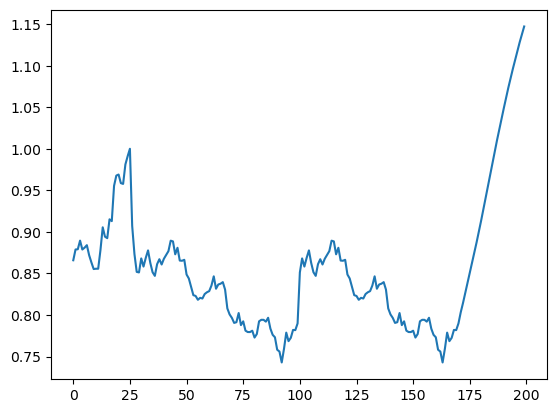

In [124]:
plt.plot(np.append(temp, x_input))